In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from pathlib import Path
import cv2
import numpy as np
import albumentations as A
from torchvision import transforms as TF
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import torchvision
import tqdm
from albumentations.pytorch import ToTensorV2
from torch.nn.utils.rnn import pad_sequence
import json

In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [63]:
class DogsDataset(Dataset):
    def __init__(self, train):
        super().__init__()

        self.train = train
        
        if self.train:
            self.data = pd.read_csv('data/dog-breed-identification/labels.csv')
            self.img_dir = Path('data/dog-breed-identification/train/')
            self.data['path'] = self.data['id'].apply(lambda x: self.img_dir / f'{x}.jpg')
            
            labels = self.data['breed'].drop_duplicates().sort_values()
            self.classes = {label: i for i, label in enumerate(labels)}
            self.classes_inv = {i: label for i, label in enumerate(labels)}            
            
            self.weights = self.data['breed'].replace(self.classes).value_counts().sort_index()
            self.weights = self.weights.min() / self.weights
            self.weights = self.weights.values
        else:
            self.img_dir = Path('data/dog-breed-identification/test/')
            self.data = pd.DataFrame({'path': self.img_dir.glob('*.jpg')})
            self.data['id'] = self.data['path'].apply(lambda x: x.stem)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = cv2.imread(str(self.data.iloc[index]['path']))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.train:
            label = self.classes[self.data.iloc[index]['breed']]
            # label = torch.Tensor([label]).long()
            return img, label
        else:
            return img, 0
        

class DogsSmallDataset(Dataset):
    def __init__(self, classes):
        super().__init__()

        self.data = pd.read_csv('data/dog-breed-identification/labels.csv')
        self.img_dir = Path('data/dog-breed-identification/train/')
        self.data['path'] = self.data['id'].apply(lambda x: self.img_dir / f'{x}.jpg')
        self.data = self.data[self.data['breed'].isin(classes)]
        
        labels = self.data['breed'].drop_duplicates().sort_values()
        self.classes = {label: i for i, label in enumerate(labels)}
        self.classes_inv = {i: label for i, label in enumerate(labels)}
        
        self.weights = self.data['breed'].replace(self.classes).value_counts().sort_index()
        self.weights = self.weights.min() / self.weights
        self.weights = self.weights.values

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = cv2.imread(str(self.data.iloc[index]['path']))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.classes[self.data.iloc[index]['breed']]
        return img, label


class SubsetWrapper(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(image=x)['image']
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [33]:
classes = [
    'borzoi',
    'boxer'
    'chow',
    'collie',
    'cocker_spaniel',
    'german_shepherd',
    'chihuahua',
    'golden_retriever',
    'malamute',
    'doberman',
    'yorkshire_terrier',
]

In [34]:
dataset = DogsDataset(train=True)
# dataset = DogsSmallDataset(classes)

sift_features_means = np.load('sift_features_means.npy')
sift_features_stds = np.load('sift_features_stds.npy')

train_transform = A.Compose([
    A.Resize(300, 300),

    A.RandomCrop(width=224, height=224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),

    A.Normalize(),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(224, 224),

    A.Normalize(),
    ToTensorV2(),
])

def sift(image, **kwargs):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(image, None)
    des = np.array([[*p.pt, *d] for p, d in zip(kp, des)])
    des[:, :2] /= image.shape
    return des

def toTensor(image, **kwargs):
    return torch.Tensor(image)

def normalize_sift(means, stds):
    def normalize(image, **kwargs):
        image = (image - means) / stds
        return image
    return normalize

sift_train_transform = A.Compose([
    A.Resize(300, 300),

    A.RandomCrop(width=224, height=224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),

    A.Lambda(sift),

    A.Lambda(normalize_sift(sift_features_means, sift_features_stds)),
    A.Lambda(toTensor)
])

sift_val_transform = A.Compose([
    A.Resize(224, 224),

    A.Lambda(sift),

    A.Lambda(normalize_sift(sift_features_means, sift_features_stds)),
    A.Lambda(toTensor)
])

train_ds, val_ds = torch.utils.data.random_split(dataset,
                                                 [.8, .2])

sift_train_ds, sift_val_ds = SubsetWrapper(train_ds, sift_train_transform), SubsetWrapper(val_ds, sift_val_transform)

train_ds = SubsetWrapper(train_ds, train_transform)
val_ds = SubsetWrapper(val_ds, val_transform)


_ = train_ds[0], val_ds[0], sift_train_ds[0], sift_val_ds[0]

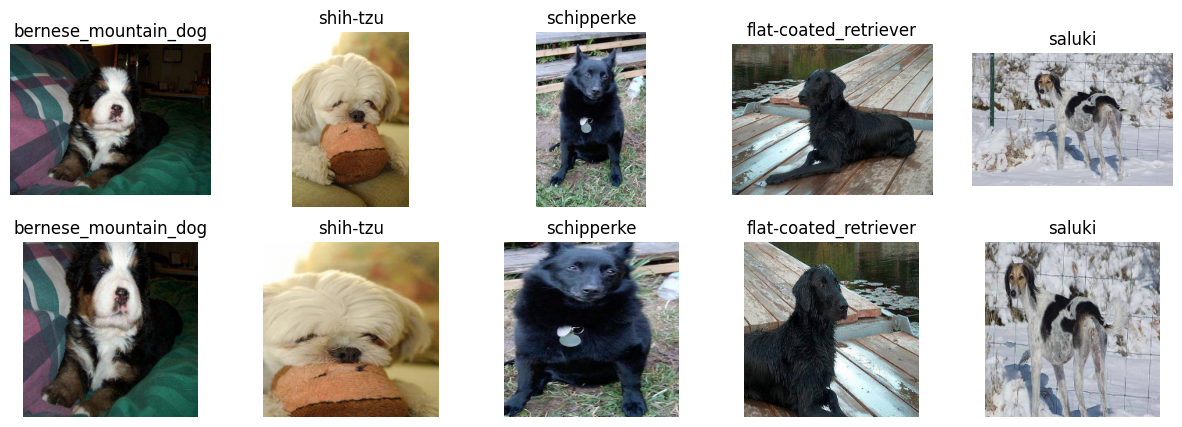

In [35]:
n = 5
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random.sample(range(len(dataset)), n)):
    x, y = dataset[idx]

    augmented_x = train_transform(image=x)['image']
    augmented_x = augmented_x.permute(1, 2, 0).numpy()
    augmented_x = augmented_x * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    augmented_x = augmented_x * 255
    augmented_x = augmented_x.astype(np.uint8)

    plt.subplot(2, n, i+1)
    plt.imshow(x)
    plt.title(dataset.classes_inv[y])
    plt.axis('off')

    plt.subplot(2, n, i+1+n)
    plt.imshow(augmented_x)
    plt.title(dataset.classes_inv[y])
    plt.axis('off')
    
    

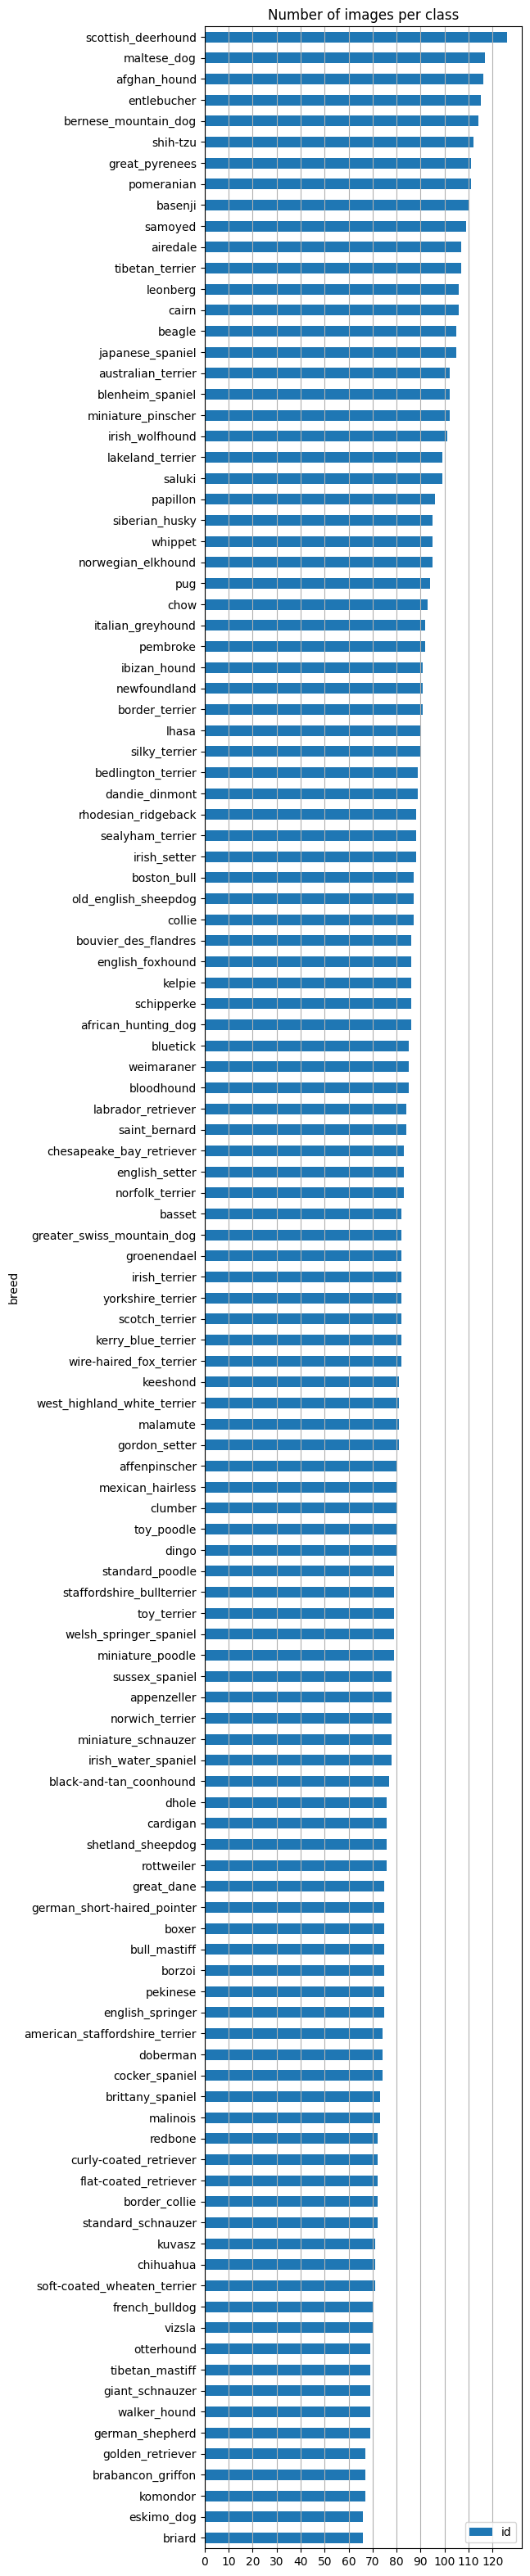

In [7]:
ax = dataset.data.groupby('breed')[['id']].count().sort_values('id', ascending=True).plot.barh(figsize=(5, 40))
ax.set_title('Number of images per class')
ax.grid(axis='x')
ax.set_xticks(range(0, 130, 10))
plt.show()

In [8]:
resnet18_1 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
resnet18_1.fc = nn.Identity()

resnet18_2 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
resnet18_2.fc = nn.Identity()

In [9]:
efficientnet_b0_1 = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT)
efficientnet_b0_1.classifier = nn.Identity()

efficientnet_b0_2 = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT)
efficientnet_b0_2.classifier = nn.Identity()

In [10]:
def make_mlp(in_features, out_features=120, hidden_sz = 3, hidden_features=200):
    if hidden_features is None:
        hidden_features = in_features

    hidden = []

    for i in range(hidden_sz):
        hidden.append(nn.Linear(hidden_features, hidden_features))
        hidden.append(nn.Tanh())

    mlp = nn.Sequential(
        nn.Linear(in_features, hidden_features),
        nn.Tanh(),

        *hidden,

        nn.Linear(hidden_features, out_features)
    )

    return mlp

In [11]:
class SIFTLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(130, 130, num_layers=2)
    
    def forward(self, batch):
        y, hidden = self.rnn(batch)
        return y[-1]

In [12]:
class DogModel(nn.Module):
    def __init__(self, feature_extractor, classifier):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.classifier = classifier
    
    def forward(self, batch):
        features = self.feature_extractor(batch)
        y = self.classifier(features)
        return y

In [13]:
models = {
    'resnet18-slp': DogModel(resnet18_1, make_mlp(512, len(dataset.classes), 0)),
    'resnet18-mlp': DogModel(resnet18_2, make_mlp(512, len(dataset.classes), 3)),
    
    'sift_lstm-slp': DogModel(SIFTLSTM(), make_mlp(130, len(dataset.classes), 0)),
    'sift_lstm-mlp': DogModel(SIFTLSTM(), make_mlp(130, len(dataset.classes), 3)),
    
    # 'efficientnet_b0-slp': DogModel(efficientnet_b0_1, make_mlp(1280, 120, 0)),
    # 'efficientnet_b0-mlp': DogModel(efficientnet_b0_2, make_mlp(1280, 120, 3)),

}

In [14]:
if torch.backends.mps.is_available():
        device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Training on {device}')

Training on mps


In [ ]:

train_metrics = {}

for model_name, model in models.items():

    if isinstance(model.feature_extractor, SIFTLSTM):
        def collate_fn(batch):
            batch.sort(key=lambda x: len(x[0]), reverse=True)
            sequences, targets = zip(*batch)
            padded_sequences = pad_sequence(sequences)
            targets = torch.Tensor(targets).long()
            return padded_sequences, targets

        train_loader = DataLoader(sift_train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(sift_val_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)
    else:
        train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)


    model = model.to(device)

    criterion = nn.CrossEntropyLoss(weight=torch.Tensor(dataset.weights))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    num_epochs = 20

    train_losses = []
    val_losses = []

    train_metrics[model_name] = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        train_true = []
        train_pred = []
        
        val_loss = 0.0
        val_true = []
        val_pred = []
        
        model.train()
        for images, labels in tqdm.tqdm(train_loader, total=len(train_loader), desc=f'{model_name} Epoch {epoch+1}'):
            images = images.to(device)
            outputs = model(images).to('cpu')
            
            train_true.extend(labels)
            train_pred.extend(outputs.argmax(1))
            
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        train_true = torch.stack(train_true)
        train_pred = torch.stack(train_pred)
        
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm.tqdm(val_loader, total=len(val_loader), desc=f'{model_name} Epoch {epoch+1}'):
                images = images.to(device)
                outputs = model(images).to('cpu')

                val_true.extend(labels)
                val_pred.extend(outputs.argmax(1))
                
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
            
            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)
            val_true = torch.stack(val_true)
            val_pred = torch.stack(val_pred)
        
        metrics = {
            'train': {
                'loss': train_loss,
                'accuracy': accuracy_score(train_true, train_pred),
                'precision': precision_score(train_true, train_pred, average='macro', zero_division=0),
                'recall': recall_score(train_true, train_pred, average='macro', zero_division=0),
                'f1': f1_score(train_true, train_pred, average='macro', zero_division=0)
            },
            'validation': {
                'loss': val_loss,
                'accuracy': accuracy_score(val_true, val_pred),
                'precision': precision_score(val_true, val_pred, average='macro', zero_division=0),
                'recall': recall_score(val_true, val_pred, average='macro', zero_division=0),
                'f1': f1_score(val_true, val_pred, average='macro', zero_division=0)
            }
        }

        train_metrics[model_name].append(metrics)

        with open('small-metrics.json', 'w') as f:
            json.dump(train_metrics, f, indent=4)

        torch.save(model, f'models/small-{model_name}-{epoch+1}.pth')
        
        print(metrics['train']['loss'], metrics['validation']['loss'], metrics['train']['accuracy'], metrics['validation']['accuracy'])
        print()


In [15]:
with open('metrics.json') as fp:
    train_metrics = json.load(fp)

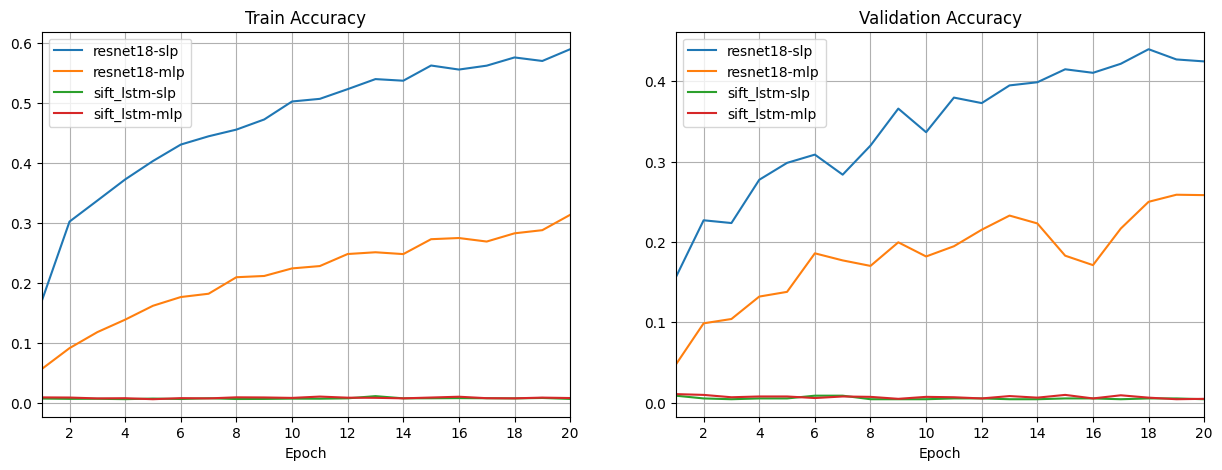

In [19]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for model_name, model in models.items():
    plt.plot(range(1, len(train_metrics[model_name])+1), [m['train']['accuracy'] for m in train_metrics[model_name]], label=model_name)
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(0, 21, 2))
plt.xlim(1, 20)
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
for model_name, model in models.items():
    plt.plot(range(1, len(train_metrics[model_name])+1), [m['validation']['accuracy'] for m in train_metrics[model_name]], label=model_name)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(0, 21, 2))
plt.xlim(1, 20)
plt.grid()
plt.legend()

plt.show()

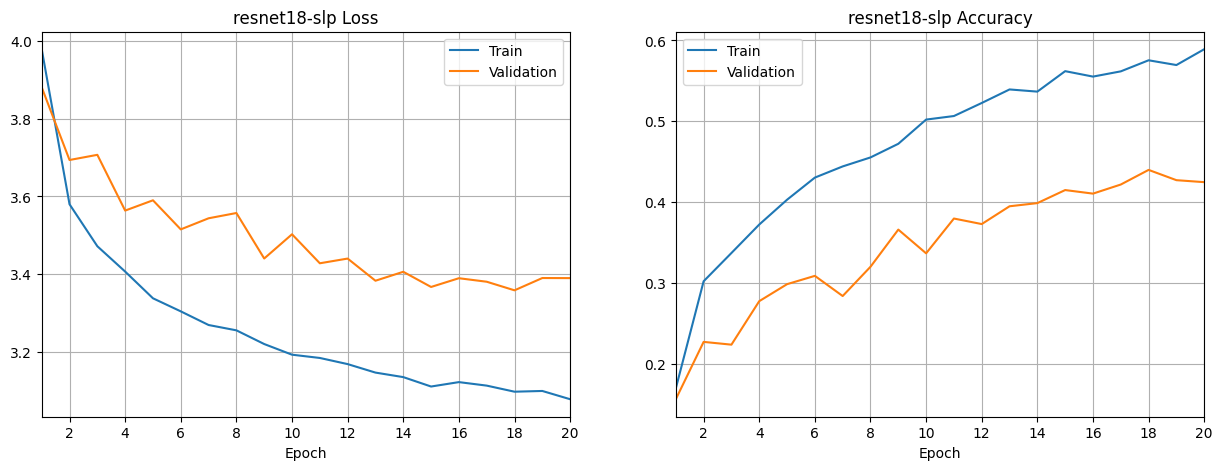

In [20]:
model_name = 'resnet18-slp'
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_metrics[model_name])+1), [m['train']['loss'] for m in train_metrics[model_name]], label='Train')
plt.plot(range(1, len(train_metrics[model_name])+1), [m['validation']['loss'] for m in train_metrics[model_name]], label='Validation')
plt.title(f'{model_name} Loss')
plt.xlabel('Epoch')
plt.xticks(range(0, 21, 2))
plt.xlim(1, 20)
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_metrics[model_name])+1), [m['train']['accuracy'] for m in train_metrics[model_name]], label='Train')
plt.plot(range(1, len(train_metrics[model_name])+1), [m['validation']['accuracy'] for m in train_metrics[model_name]], label='Validation')
plt.title(f'{model_name} Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(0, 21, 2))
plt.xlim(1, 20)
plt.grid()
plt.legend()

plt.show()

In [21]:
model = torch.load('models/resnet18-slp-20.pth')
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

val_true = []
val_pred = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm.tqdm(val_loader, total=len(val_loader)):
        images = images.to(device)
        outputs = model(images).to('cpu')

        val_true.extend(labels)
        val_pred.extend(outputs.argmax(1))
        
    val_true = torch.stack(val_true)
    val_pred = torch.stack(val_pred)

100%|██████████| 32/32 [00:05<00:00,  5.88it/s]


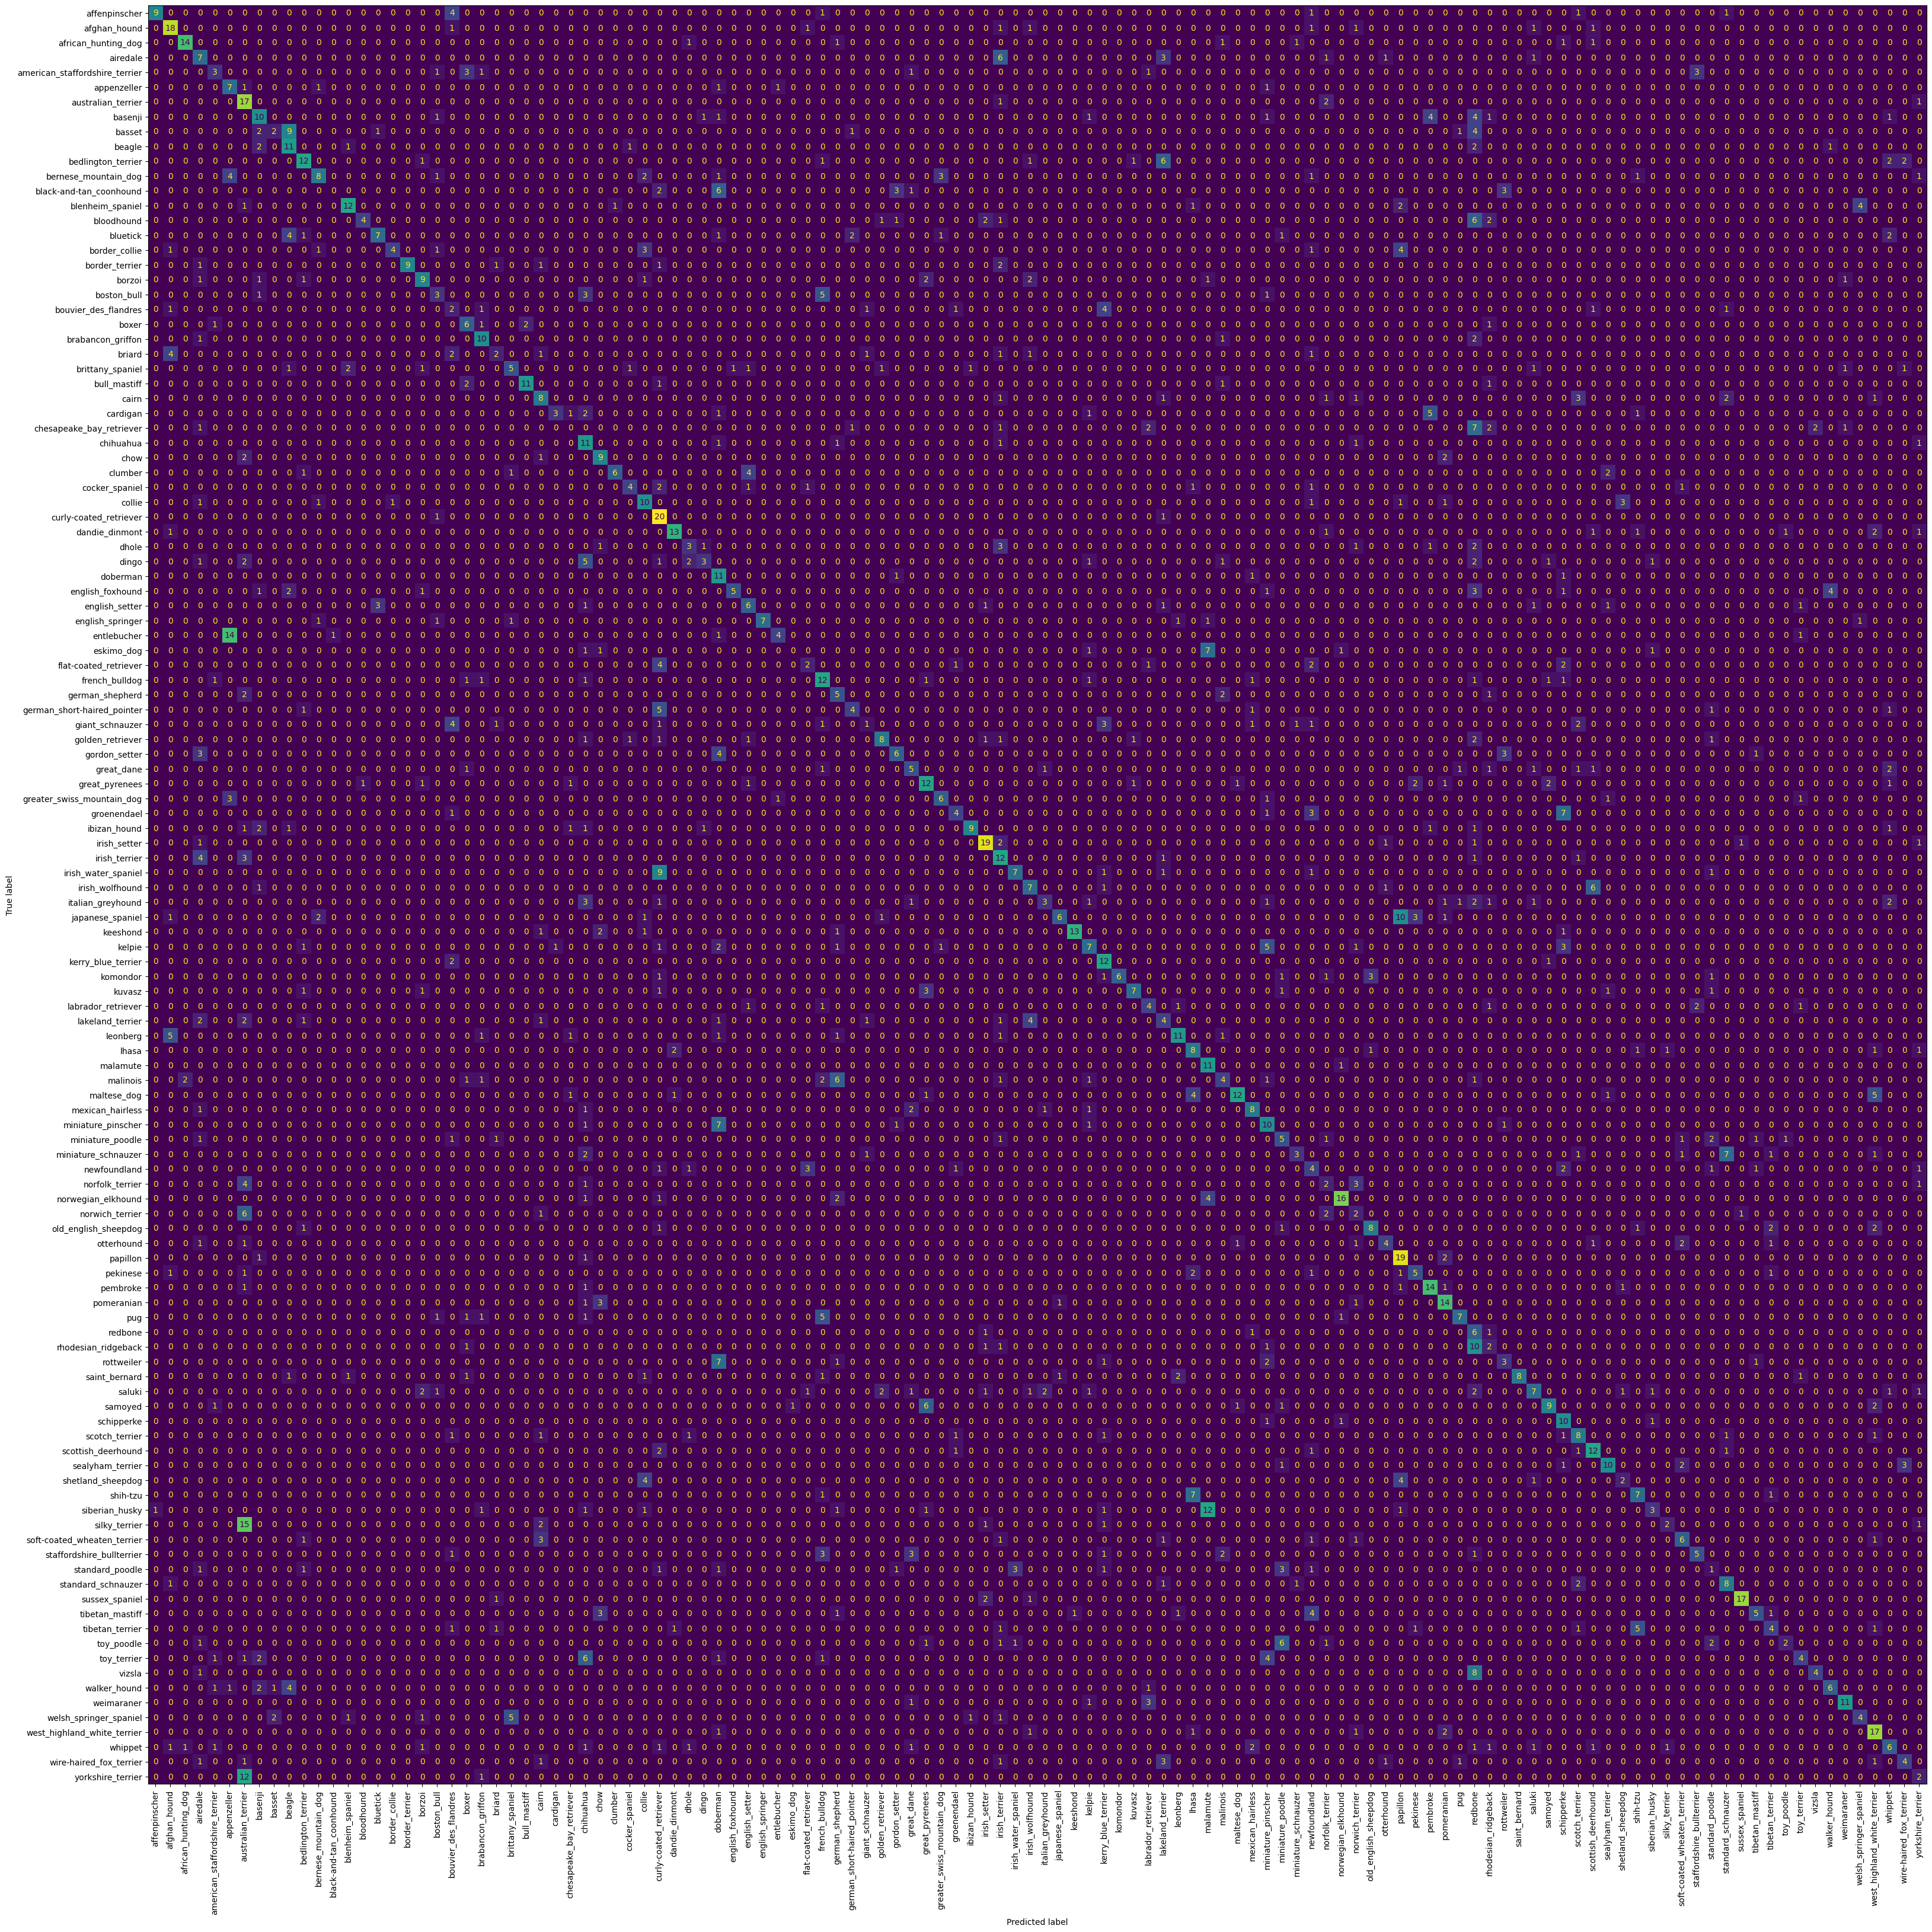

In [22]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_axes([0,0,1,1])

plot = ConfusionMatrixDisplay.from_predictions(
    val_true,
    val_pred,
    labels=range(len(dataset.classes)),
    display_labels=list(dataset.classes_inv.values()),
    colorbar=False,
    normalize=None,
    ax=ax
)

plt.xticks(rotation=90)

plt.show()

In [69]:
model = torch.load('models/resnet18-slp-20.pth')

model.classifier[-1] = nn.Identity()

test_ds = DogsDataset(False)
test_transformations = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2(),
])
test_ds = SubsetWrapper(test_ds, test_transformations)

test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

test_pred = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader, total=len(test_loader)):
        images = images.to(device)
        logits = model(images)

        prob = nn.functional.softmax(logits, dim=1)

        prob = prob.to('cpu')

        test_pred.extend(prob)
        
    test_pred = torch.stack(test_pred)

test_result = pd.DataFrame(test_pred.numpy(), columns=dataset.classes_inv.values())
test_result.index = test_ds.subset.data['id']
test_result.to_csv('test_result.csv')
test_result

100%|██████████| 162/162 [00:27<00:00,  5.98it/s]


,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
id,,,,,,,,,,,,,,,,,,,,,
266490a2b053a4a3bf68e779f28fb5a9,0.000011,0.000060,0.000049,0.003949,0.000128,0.000852,0.000138,0.000172,0.000071,0.000084,...,0.000074,0.000373,0.000457,0.000111,0.000589,0.000007,0.000017,0.000025,0.000078,0.000051
dae9fd18836d8df20989ef0101771d4b,0.000158,0.011808,0.000135,0.000060,0.000008,0.000246,0.000098,0.000027,0.000018,0.000034,...,0.000016,0.000024,0.000034,0.000011,0.000143,0.000102,0.000302,0.000622,0.000042,0.000143
079a40f22b0fad9a66f76797b62bb930,0.000447,0.000174,0.000173,0.000102,0.000044,0.000023,0.000033,0.000019,0.000003,0.000008,...,0.000785,0.000006,0.000059,0.000016,0.000045,0.000035,0.000006,0.000004,0.000019,0.000003
ab8462f9a501d362041d47582fddc9ad,0.000020,0.001347,0.000041,0.005423,0.000007,0.000295,0.000356,0.000025,0.000024,0.000004,...,0.000107,0.000105,0.000247,0.000066,0.000109,0.000065,0.000003,0.000004,0.000028,0.000412
8895089b432e020cc42e6262b5a1c2dd,0.000046,0.000020,0.000258,0.000414,0.000115,0.000027,0.001893,0.000879,0.000011,0.000038,...,0.000137,0.000142,0.000053,0.000014,0.000022,0.000134,0.000137,0.000102,0.000267,0.000025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e6d6ff5b33e6174158d5ab05a7eda95c,0.000035,0.000087,0.000297,0.004544,0.000958,0.000145,0.000262,0.000026,0.000160,0.000117,...,0.002064,0.000344,0.000275,0.000110,0.001493,0.000608,0.000059,0.000054,0.055039,0.000284
474a1be9d5932a9e75b28384961ad17f,0.000125,0.000145,0.016176,0.004567,0.000121,0.000041,0.000315,0.000050,0.000015,0.000092,...,0.000259,0.000225,0.000047,0.000039,0.000688,0.000121,0.000421,0.000753,0.000181,0.000072
1b7421b4d34056c04a9b2d109e503fe4,0.000285,0.000376,0.003312,0.000040,0.009468,0.000956,0.002038,0.005874,0.000952,0.000573,...,0.000430,0.008401,0.000326,0.000685,0.001148,0.006328,0.001079,0.003556,0.000271,0.007408
